# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [155]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np


# imblearn modules
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [156]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
 # Replace with the actual column names
fm_df = d.drop(columns=['dt_first_pi', 'dt_matr', 'id_loan_rr'])
fm_df = fm_df.set_index('id_loan')
# Select relevant columns given by [1]
#fm_df = d[['fico', 'mi_pct', 'cnt_units', 'dti', 'orig_upb', 'int_rt', 'cnt_borr', 'flag_fthb', 'occpy_sts', 'prop_type', 'loan_status']]
# Filter for only prepaid or defaulted mortgages
fm_df = fm_df[fm_df['loan_status'].isin(['prepaid', 'default'])]
categorical_features = fm_df.select_dtypes(include=['object', 'category']).columns.tolist()

C:\Users\User\AppData\Local\Temp\ipykernel_1856\1893388474.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


In [153]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126705 entries, F17Q10000002 to F20Q41283692
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            126705 non-null  int64  
 1   flag_fthb       126705 non-null  object 
 2   cd_msa          115411 non-null  float64
 3   mi_pct          126705 non-null  int64  
 4   cnt_units       126705 non-null  int64  
 5   occpy_sts       126705 non-null  object 
 6   cltv            126705 non-null  int64  
 7   dti             126705 non-null  int64  
 8   orig_upb        126705 non-null  int64  
 9   ltv             126705 non-null  int64  
 10  int_rt          126705 non-null  float64
 11  channel         126705 non-null  object 
 12  ppmt_pnlty      126705 non-null  object 
 13  prod_type       126705 non-null  object 
 14  st              126705 non-null  object 
 15  prop_type       126705 non-null  object 
 16  zipcode         126705 non-null  int64  
 17

In [157]:
fm_df['fico'] = fm_df['fico'].replace(9999, np.nan)
#fm_df['dt_first_pi'] = fm_df['dt_first_pi'].replace(999999, np.nan)  # Assuming 999999 for invalid dates
fm_df['flag_fthb'] = fm_df['flag_fthb'].replace('9', np.nan)
#fm_df['dt_matr'] = fm_df['dt_matr'].replace(999999, np.nan)  # Assuming 999999 for invalid dates
fm_df['cd_msa'] = fm_df['cd_msa'].replace(0, np.nan)  # Assuming 0 for not available
fm_df['mi_pct'] = fm_df['mi_pct'].replace(999, np.nan)
fm_df['cnt_units'] = fm_df['cnt_units'].replace(99, np.nan)
fm_df['occpy_sts'] = fm_df['occpy_sts'].replace('9', np.nan)
fm_df['cltv'] = fm_df['cltv'].replace(999, np.nan)
fm_df['dti'] = fm_df['dti'].replace(999, np.nan)
fm_df['ltv'] = fm_df['ltv'].replace(999, np.nan)
fm_df['channel'] = fm_df['channel'].replace('9', np.nan)
fm_df['prop_type'] = fm_df['prop_type'].replace('99', np.nan)
fm_df['zipcode'] = fm_df['zipcode'].replace(0, np.nan)  # Assuming 0 for unknown zip codes
fm_df['loan_purpose'] = fm_df['loan_purpose'].replace('9', np.nan)
fm_df['program_ind'] = fm_df['program_ind'].replace('9', np.nan)
fm_df['rr_ind'] = fm_df['rr_ind'].replace('N', np.nan)
fm_df['property_val'] = fm_df['property_val'].replace(9, np.nan)
fm_df['mi_cancel_ind'] = fm_df['mi_cancel_ind'].replace(['7', '9'], np.nan)

In [94]:
# Check for missing values
fico_count = fm_df[fm_df['fico'] == 9999].shape[0]
mi_pct_count = fm_df[fm_df['mi_pct'] == 999].shape[0]
cnt_units_count = fm_df[fm_df['cnt_units'] == 99].shape[0]
dti_count = fm_df[fm_df['dti'] == 999].shape[0]
flag_fthb_count = fm_df[fm_df['flag_fthb'] == '9'].shape[0]
occpy_sts_count = fm_df[fm_df['occpy_sts'] == '9'].shape[0]
prop_type_count = fm_df[fm_df['prop_type'] == '99'].shape[0]
# Print number of missing values
print(fico_count, mi_pct_count, cnt_units_count, dti_count, flag_fthb_count, occpy_sts_count, prop_type_count)

24 1 0 1304 0 0 0


Loan Status Counts:
loan_status
prepaid    125959
default       746
Name: count, dtype: int64

Loan Status Percentages:
loan_status
prepaid    99.411231
default     0.588769
Name: proportion, dtype: float64


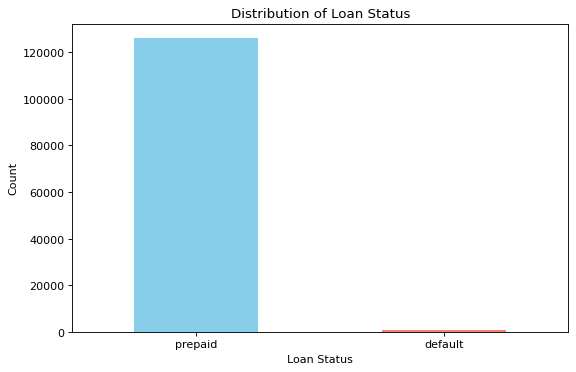

In [110]:
import matplotlib.pyplot as plt

# Calculate the distribution of loan_status
loan_status_counts = fm_df['loan_status'].value_counts()
loan_status_percent = fm_df['loan_status'].value_counts(normalize=True) * 100

# Print the counts and percentages
print("Loan Status Counts:")
print(loan_status_counts)
print("\nLoan Status Percentages:")
print(loan_status_percent)

# Visualize the imbalance with a bar chart
plt.figure(figsize=(8, 5))
loan_status_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [95]:
fm_df['fico'] = fm_df['fico'].replace(9999, np.nan)
fm_df['mi_pct'] = fm_df['mi_pct'].replace(999, np.nan)
fm_df['dti'] = fm_df['dti'].replace(999, np.nan)

In [158]:
# Feature matrix and response vector
X, y = fm_df.drop(['loan_status'], axis=1), fm_df['loan_status']
# Encode target
y = LabelEncoder().fit_transform(y)
# Split test and train with similar proportion of default and prepaid
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, test_size=0.2, random_state=0
)

In [128]:
import pandas as pd

# Combine X_train and y_train into a single DataFrame for correlation analysis
X_train['target'] = y_train

# Select only numeric columns for correlation computation
numeric_X_train = X_train.select_dtypes(include=['number'])

# Compute correlations between numerical features and the target
correlations = numeric_X_train.corr()['target'].drop('target')

# Sort correlations by absolute value
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Print the correlations
print("Correlation of features with the target:")
print(sorted_correlations)

# Select features with high correlation (e.g., > 0.1)
selected_features = sorted_correlations[sorted_correlations > 0.1].index.tolist()
print("Selected features based on correlation:", selected_features)

# Drop the target column from X_train
X_train = X_train.drop(columns=['target'])

Correlation of features with the target:
fico              0.058235
property_val      0.029817
cnt_borr          0.024867
dti               0.023795
orig_upb          0.019636
int_rt            0.018892
cltv              0.015703
cnt_units         0.015581
ltv               0.014182
zipcode           0.012618
mi_pct            0.009676
cd_msa            0.002981
orig_loan_term    0.001423
Name: target, dtype: float64
Selected features based on correlation: []


In [141]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Apply pairwise
for col in categorical_features:
    score = cramers_v(X_train[col], y_train)
    print(f"Cramér's V between {col} and target: {score:.3f}")

Cramér's V between flag_fthb and target: 0.011
Cramér's V between occpy_sts and target: 0.015
Cramér's V between channel and target: 0.007
Cramér's V between ppmt_pnlty and target: nan
Cramér's V between prod_type and target: nan


C:\Users\User\AppData\Local\Temp\ipykernel_1856\4265611066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
C:\Users\User\AppData\Local\Temp\ipykernel_1856\4265611066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


Cramér's V between st and target: 0.035
Cramér's V between prop_type and target: 0.027
Cramér's V between loan_purpose and target: 0.008
Cramér's V between seller_name and target: 0.031
Cramér's V between servicer_name and target: 0.079
Cramér's V between flag_sc and target: nan
Cramér's V between id_loan_rr and target: 1.000
Cramér's V between program_ind and target: 0.019
Cramér's V between rr_ind and target: nan
Cramér's V between io_ind and target: nan
Cramér's V between mi_cancel_ind and target: 0.005


C:\Users\User\AppData\Local\Temp\ipykernel_1856\4265611066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
C:\Users\User\AppData\Local\Temp\ipykernel_1856\4265611066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))
C:\Users\User\AppData\Local\Temp\ipykernel_1856\4265611066.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min(k - 1, r - 1))


In [ ]:
# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocess the data: One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Keep numerical features as is
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Transform X_train to ensure all features are numeric
X_train_encoded = preprocessor.fit_transform(X_train)

# Convert the transformed data back to a DataFrame for compatibility
X_train_encoded = pd.DataFrame(X_train_encoded.toarray() if hasattr(X_train_encoded, 'toarray') else X_train_encoded)

# Perform Recursive Feature Elimination (RFE)
rf_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=1, step=1)  # Select features one by one
rfe.fit(X_train_encoded, y_train)

# Get feature rankings
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

# Print feature rankings
print("Feature rankings based on RFE:")
print(feature_ranking)

Selected Features (Importance > 0.01):
                                               Feature  Importance
6                                        num__orig_upb    0.088771
0                                            num__fico    0.088427
9                                         num__zipcode    0.073602
8                                          num__int_rt    0.072239
5                                             num__dti    0.069113
1                                          num__cd_msa    0.059373
4                                            num__cltv    0.048528
7                                             num__ltv    0.046210
11                                       num__cnt_borr    0.016255
173  cat__servicer_name_SPECIALIZED LOAN SERVICING LLC    0.014223
160                 cat__servicer_name_Other servicers    0.013815
113                     cat__seller_name_Other sellers    0.012927
10                                 num__orig_loan_term    0.012084
2                      

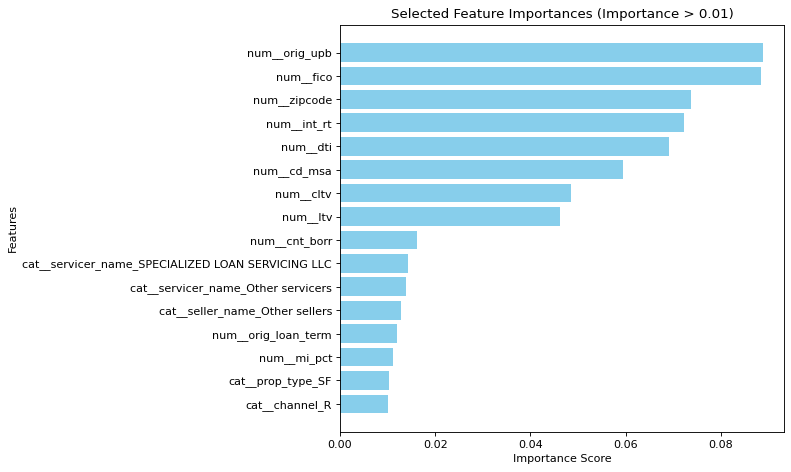

List of selected feature names: ['num__orig_upb', 'num__fico', 'num__zipcode', 'num__int_rt', 'num__dti', 'num__cd_msa', 'num__cltv', 'num__ltv', 'num__cnt_borr', 'cat__servicer_name_SPECIALIZED LOAN SERVICING LLC', 'cat__servicer_name_Other servicers', 'cat__seller_name_Other sellers', 'num__orig_loan_term', 'num__mi_pct', 'cat__prop_type_SF', 'cat__channel_R']


In [159]:
# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Retrieve the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Combine feature names with their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Filter features with importance score > 0.01
selected_features = importance_df[importance_df['Importance'] > 0.01]

# Print the selected features
print("Selected Features (Importance > 0.01):")
print(selected_features)

# Plot the selected feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], selected_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Selected Feature Importances (Importance > 0.01)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Get the list of selected feature names
selected_feature_names = selected_features['Feature'].tolist()
print("List of selected feature names:", selected_feature_names)

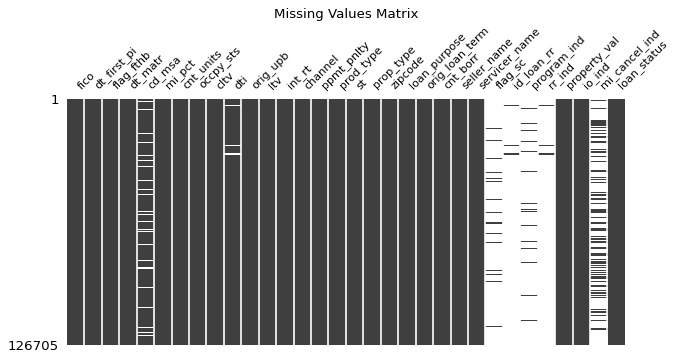

Maximum missing percentage for a variable: 98.97%


Correlation of 'cd_msa' missingness with other variables:
orig_upb          0.159477
property_val      0.076659
dt_matr           0.052522
orig_loan_term    0.047235
dti               0.042042
cnt_borr          0.032524
dt_first_pi       0.029600
fico              0.022967
mi_pct            0.009967
int_rt            0.009398
cnt_units         0.009303
zipcode           0.002088
ltv               0.002043
cltv              0.000689
cd_msa                 NaN
Name: cd_msa_missing, dtype: float64


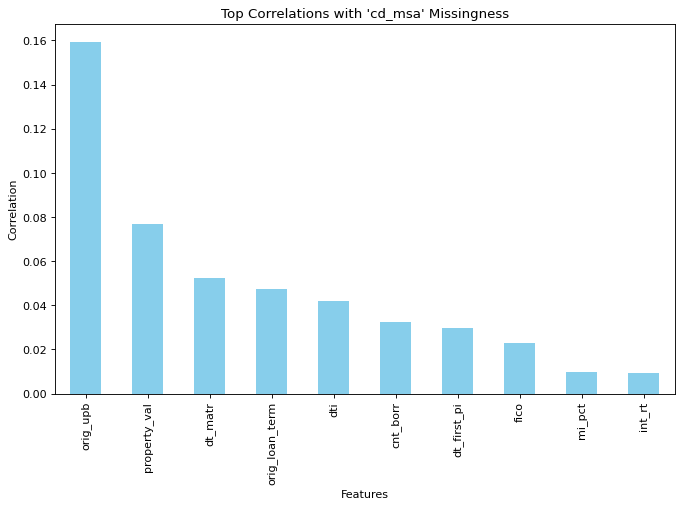

In [ ]:
import seaborn as sns

# Create a binary indicator for missingness in 'dti'
fm_df['cd_msa_missing'] = fm_df['cd_msa'].isnull().astype(int)

# Compute correlations between the missingness of 'dti' and other numeric variables
numeric_columns = fm_df.select_dtypes(include=['number'])
correlations = numeric_columns.corr()['cd_msa_missing'].drop('cd_msa_missing')

# Sort correlations by absolute value
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Print the correlations
print("Correlation of 'cd_msa' missingness with other variables:")
print(sorted_correlations)

# Visualize the top correlations
plt.figure(figsize=(10, 6)) 
sorted_correlations.head(10).plot(kind='bar', color='skyblue')
plt.title("Top Correlations with 'dti' Missingness")
plt.ylabel("Correlation")
plt.xlabel("Features")
plt.show()

In [98]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126705 entries, 0 to 199986
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fico         126681 non-null  float64
 1   mi_pct       126704 non-null  float64
 2   cnt_units    126705 non-null  int64  
 3   dti          125401 non-null  float64
 4   orig_upb     126705 non-null  int64  
 5   int_rt       126705 non-null  float64
 6   cnt_borr     126705 non-null  int64  
 7   flag_fthb    126705 non-null  object 
 8   occpy_sts    126705 non-null  object 
 9   prop_type    126705 non-null  object 
 10  loan_status  126705 non-null  object 
 11  dti_missing  126705 non-null  int32  
dtypes: float64(4), int32(1), int64(3), object(4)
memory usage: 12.1+ MB


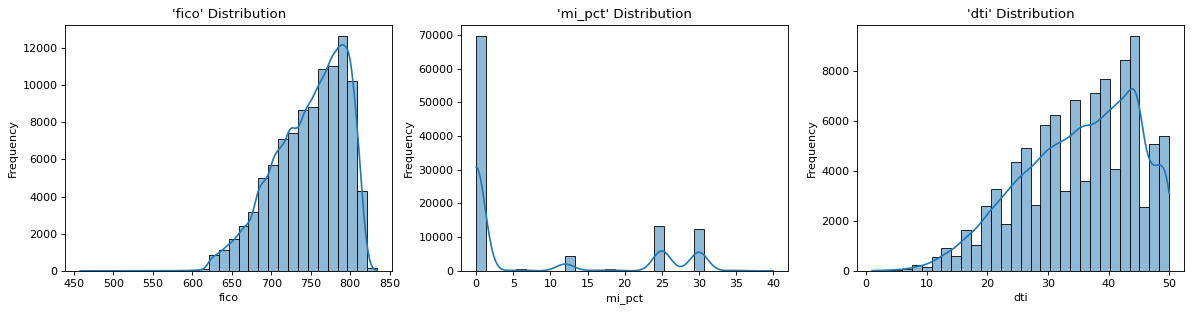

In [99]:
# Select numeric columns
numeric_missing = ['fico', 'mi_pct', 'dti']
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns
for i, col in enumerate(numeric_missing):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"'{col}' Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [100]:
# Change variable types 
fm_df['cnt_units'] = fm_df['cnt_units'].astype('object')
fm_df['cnt_borr'] = fm_df['cnt_borr'].astype('object')
# Create a list of categorical columns
categorical = fm_df.select_dtypes(include=['object']).drop(columns=['loan_status']).columns.tolist()
# Create a list of numerical columns
numerical = fm_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Create lists for impution type
median_impute = ['fico', 'dti']
mode_impute = ['mi_pct']
# Numerical imputer pipeline
num_imputer = Pipeline([
    ('impute', ColumnTransformer([
    ("mode_impute", SimpleImputer(strategy='most_frequent'), mode_impute),
    ("median_impute", SimpleImputer(strategy='median'), median_impute)
], remainder='passthrough'))])
# Categorical onehotencoder pipeline
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
])
# Nest pipelines then standardise
pre_processing = Pipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler())
])

In [60]:
# Final pipeline
baseline_pipeline = Pipeline([
    ("pre_processing", pre_processing),
    ("classifier", LogisticRegression(random_state=0, penalty=None))
])
# Fit the pipeline to the training data
baseline_pipeline = baseline_pipeline.fit(X_train, y_train)

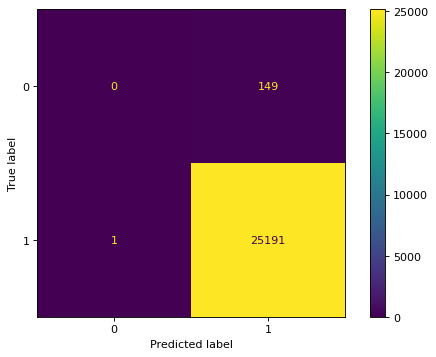

In [61]:
ConfusionMatrixDisplay.from_estimator(baseline_pipeline, X_test, y_test)
plt.show()

In [62]:
from sklearn.metrics import classification_report

print(classification_report(y_test, 
                            baseline_pipeline.predict(X_test), 
                            target_names = ['Default','Prepaid']))

              precision    recall  f1-score   support

     Default       0.00      0.00      0.00       149
     Prepaid       0.99      1.00      1.00     25192

    accuracy                           0.99     25341
   macro avg       0.50      0.50      0.50     25341
weighted avg       0.99      0.99      0.99     25341



In [63]:
log_us_pipeline = ImPipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=0)),
    ("classifier", LogisticRegression(random_state=0, penalty=None))
])

log_us_pipeline = log_us_pipeline.fit(X_train, y_train)


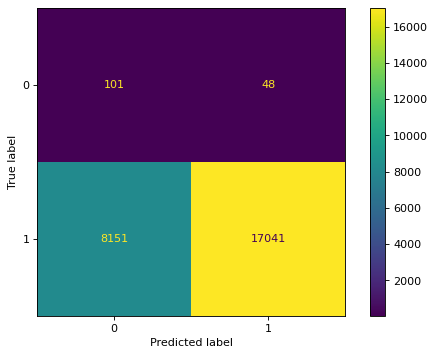

In [64]:
# Visualize the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_us_pipeline, X_test, y_test)
plt.show()

In [65]:
log_os_pipeline = ImPipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=0)),
    ("classifier", LogisticRegression(random_state=0, penalty=None))
])

log_os_pipeline = log_os_pipeline.fit(X_train, y_train)


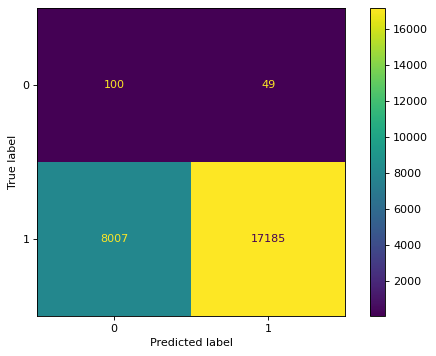

In [66]:
# Visualize the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_os_pipeline, X_test, y_test)
plt.show()

In [111]:
# Define the pipeline with SMOTE
log_smote_pipeline = ImPipeline([
    ("column_transform", ColumnTransformer([
        ("num_impute", num_imputer, numerical),
        ("cat_pre", cat_pipeline, categorical)
    ])),
    ("scaler", StandardScaler()),
    ("sampler", SMOTE(random_state=0)),  # Use SMOTE for oversampling
    ("classifier", LogisticRegression(random_state=0, penalty=None))
])

# Fit the pipeline
log_smote_pipeline = log_smote_pipeline.fit(X_train, y_train)

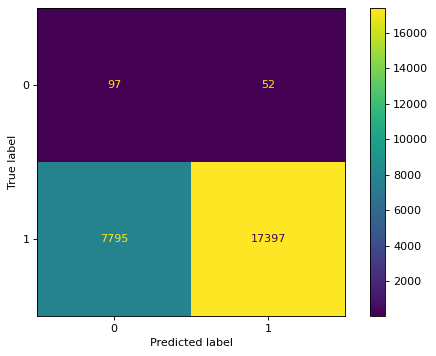

In [112]:
# Visualize the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_smote_pipeline, X_test, y_test)
plt.show()

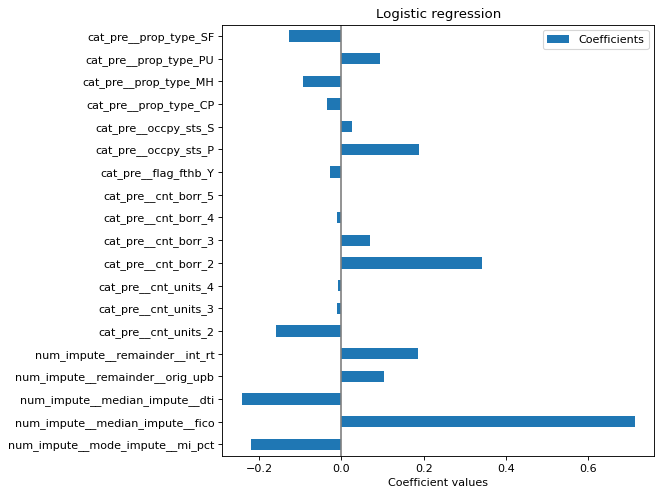

In [31]:
# Create dataframe with coefficients
coefs = pd.DataFrame(
    np.copy(log_us_pipeline.named_steps['classifier'].coef_).T,
    columns=["Coefficients"],
    index=pre_processing.named_steps['column_transform'].get_feature_names_out()
)

# Plot the coefficients
coefs.plot.barh(figsize=(9, 7))
plt.title("Logistic regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

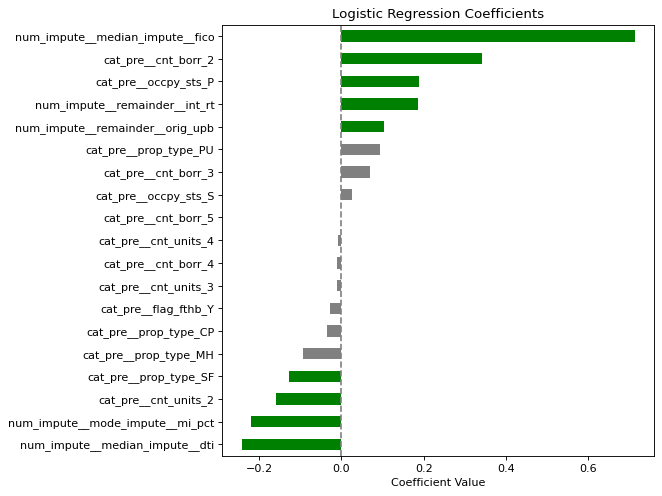

In [37]:
coefs['Significance'] = coefs['Coefficients'].abs() > 0.1  # You can tune this threshold
import seaborn as sns
import matplotlib.pyplot as plt

# Sort for cleaner plot (optional)
coefs_sorted = coefs.sort_values(by="Coefficients")

# Set up color: significant → one color, not → another
colors = coefs_sorted['Significance'].map({True: 'green', False: 'gray'})

# Plot
plt.figure(figsize=(9, 7))
coefs_sorted['Coefficients'].plot.barh(color=colors)
plt.title("Logistic Regression Coefficients")
plt.axvline(x=0, color=".5", linestyle='--')
plt.xlabel("Coefficient Value")
plt.subplots_adjust(left=0.3)
plt.show()


In [36]:
import statsmodels.api as sm
# Preprocess the data using the pre_processing step of the pipeline
preprocessed_data = pre_processing.fit_transform(X_train)

# Add an intercept to the preprocessed data
preprocessed_data_with_intercept = sm.add_constant(preprocessed_data)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, preprocessed_data_with_intercept).fit()

# Display the summary, which includes p-values
print(logit_model.summary())

         Current function value: 0.033532
         Iterations: 35


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               101364
Model:                          Logit   Df Residuals:                   101344
Method:                           MLE   Df Model:                           19
Date:                Sat, 29 Mar 2025   Pseudo R-squ.:                 0.07147
Time:                        17:29:41   Log-Likelihood:                -3399.0
converged:                      False   LL-Null:                       -3660.6
Covariance Type:            nonrobust   LLR p-value:                 7.471e-99
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5742    223.676      0.025      0.980    -432.823     443.972
x1            -0.1628      0.045     -3.602      0.000      -0.251      -0.074
x2             0.6617      0.039     16.926      0.0

In [ ]:
from sklearn.model_selection import GridSearchCV
l1_ratios = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__l1_ratio': l1_ratios
}

grid_search = GridSearchCV(
    log_us_pipeline,
    param_grid=param_grid,
    scoring='f1',  # or 'recall', 'accuracy', etc. — depends on your priority
    cv=5,
    refit=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

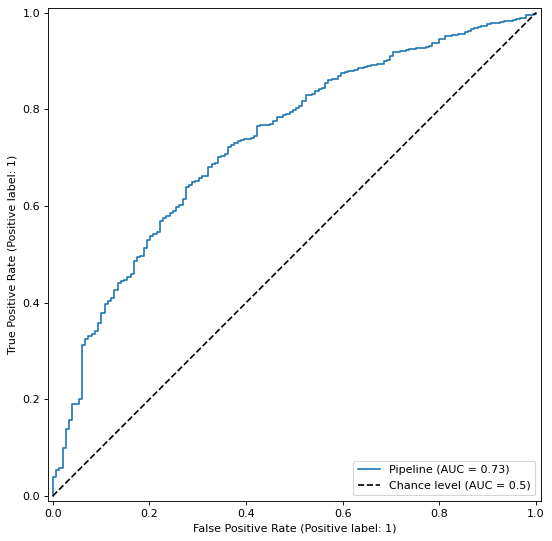

AUC: 0.7321297269187406


In [ ]:
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(log_us_pipeline, X_test, y_test,plot_chance_level=True, ax = ax)
plt.show()

# Compute the probabilities for each class on the test data (N_test by C matrix)
y_test_prob = log_us_pipeline.predict_proba(X_test)

# Compute the AUC
print('AUC:', roc_auc_score(y_test, y_test_prob[:,1]))

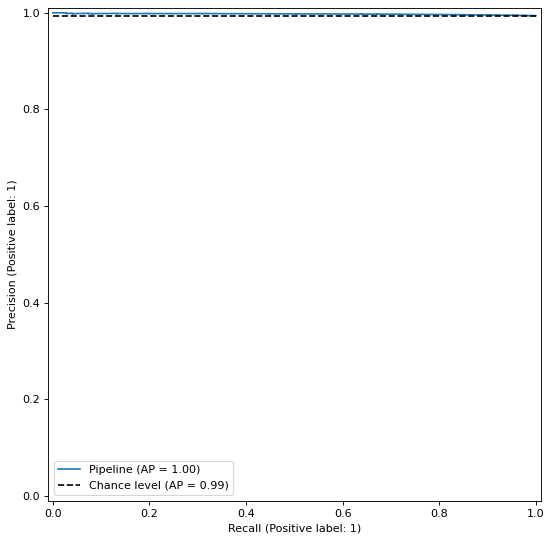

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
PrecisionRecallDisplay.from_estimator(log_us_pipeline, X_test, y_test,plot_chance_level=True, ax = ax)
plt.show()

In [ ]:
# Consider 5 folds
KF = KFold(n_splits=5)
SKF = StratifiedKFold(n_splits=5)

fold_names = ["KFold", "StratifiedKFold"]
for i, K in enumerate([KF, SKF]):
    # Initialize an empty DataFrame to store counts for the current fold type
    fold_nos = pd.DataFrame()
    for j, (train_i, test_i) in enumerate(K.split(X_train, y_train)):
        # Compute value counts for the current fold and ensure it's a DataFrame with appropriate columns
        fold_no = pd.DataFrame(pd.Series(y_train[test_i]).value_counts()).T
        fold_no.index = ["Fold " + str(j)]  # Rename the index to reflect the fold number
        # Concatenate with the fold_nos DataFrame
        fold_nos = pd.concat([fold_nos, fold_no], axis=0)
    
    fold_nos.fillna(0, inplace=True)  # Fill missing values with 0 if any class was not present in a fold
    print(f"{fold_names[i]} counts per fold:\n", fold_nos)

KFold counts per fold:
             1    0
Fold 0  20153  120
Fold 1  20154  119
Fold 2  20135  138
Fold 3  20164  109
Fold 4  20161  111
StratifiedKFold counts per fold:
             1    0
Fold 0  20154  119
Fold 1  20154  119
Fold 2  20153  120
Fold 3  20153  120
Fold 4  20153  119


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb